In [18]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import os
folder = "/content/drive/MyDrive/Colab Notebooks/dataset"
os.listdir(folder)


['ResPlan.pkl']

In [20]:
import pickle

pkl_path = "/content/drive/MyDrive/Colab Notebooks/dataset/ResPlan.pkl"

with open(pkl_path, "rb") as f:
    data = pickle.load(f)

print(type(data))


<class 'list'>


In [21]:
len(data)


17107

In [22]:
data[0]


{'balcony': <MULTIPOLYGON (((190.664 120.724, 190.664 145.219, 193.441 146.575, 194.761 ...>,
 'bathroom': <MULTIPOLYGON (((105.726 96.965, 146.71 96.965, 146.71 66.673, 105.726 66.67...>,
 'bedroom': <MULTIPOLYGON (((223.332 117.754, 223.332 73.503, 234.617 73.503, 234.617 51...>,
 'door': <MULTIPOLYGON (((226.302 102.311, 222.738 102.311, 222.738 117.16, 226.302 1...>,
 'garden': <MULTIPOLYGON EMPTY>,
 'inner': <MULTIPOLYGON (((126.812 175.963, 126.812 193.188, 163.638 193.188, 163.638 ...>,
 'parking': <MULTIPOLYGON EMPTY>,
 'pool': <MULTIPOLYGON EMPTY>,
 'stair': <MULTIPOLYGON EMPTY>,
 'veranda': <MULTIPOLYGON EMPTY>,
 'wall': <MULTIPOLYGON (((258.97 120.724, 258.97 72.91, 247.981 72.91, 247.981 76.473...>,
 'window': <MULTIPOLYGON (((237.587 72.91, 237.587 76.176, 237.587 76.473, 247.981 76.4...>,
 'front_door': <POLYGON ((0.594 51.824, -2.97 51.824, -2.97 72.91, 0.594 72.91, 0.594 51.824))>,
 'unitType': 'Apartment',
 'id': 13,
 'kitchen': <MULTIPOLYGON (((43.657 175.369, 43.657 

In [23]:
"""

Contents:
    - Color maps and constants
    - Geometry utilities (get_geometries, centroid, perturb, noise)
    - Mask conversion (geometry_to_mask)
    - Augmentations (rotate/flip/scale)
    - Buffer helpers (shrink→expand, expand→shrink)
    - Plan plotting (plot_plan)
    - Plan→graph (plan_to_graph) + graph overlay plotting (plot_plan_and_graph)
    - Dataset helpers (normalize_keys, get_plan_width)
"""

from __future__ import annotations
import math
from typing import Iterable, List, Dict, Any, Tuple, Optional, Union

import numpy as np
import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import (
    Polygon, MultiPolygon, LineString, MultiLineString, Point, GeometryCollection, base, box
)
from shapely.ops import unary_union
from shapely import affinity

# -----------------------------
# Colors & constants
# -----------------------------

CATEGORY_COLORS: Dict[str, str] = {
    "living": "#d9d9d9",    # light gray
    "bedroom": "#66c2a5",    # greenish
    "bathroom": "#fc8d62",   # orange
    "kitchen": "#8da0cb",    # blue
    "door": "#e78ac3",       # pink
    "window": "#a6d854",     # lime
    "wall": "#ffd92f",       # yellow
    "front_door": "#a63603", # dark reddish-brown
    "balcony": "#b3b3b3"     # dark gray
}

DEFAULT_CANVAS_SIZE = (256, 256)  # (H, W)

# -----------------------------
# Dataset helpers
# -----------------------------

def normalize_keys(plan: Dict[str, Any]) -> Dict[str, Any]:
    """Normalize common key typos / variations in-place (balacony→balcony)."""
    if "balacony" in plan and "balcony" not in plan:
        plan["balcony"] = plan.pop("balacony")
    return plan

def get_plan_width(plan: Dict[str, Any]) -> float:
    """Returns the max(width, height) of the inner polygon bounds."""
    inner = plan.get("inner")
    if inner is None or inner.is_empty:
        return 0.0
    x1, y1, x2, y2 = inner.bounds
    return max(x2 - x1, y2 - y1)

# -----------------------------
# Geometry utilities
# -----------------------------

def get_geometries(geom_data: Any) -> List[Any]:
    """Safely extract individual geometries from single/multi/collections."""
    if geom_data is None:
        return []
    if isinstance(geom_data, (Polygon, LineString, Point)):
        return [] if geom_data.is_empty else [geom_data]
    if isinstance(geom_data, (MultiPolygon, MultiLineString, GeometryCollection)):
        return [g for g in geom_data.geoms if g is not None and not g.is_empty]
    return []

def centroid(poly: Union[Polygon, MultiPolygon]) -> Point:
    """Centroid for Polygon/MultiPolygon (largest part if multi)."""
    if isinstance(poly, Polygon):
        return poly.centroid
    if isinstance(poly, MultiPolygon) and len(poly.geoms) > 0:
        largest = max(poly.geoms, key=lambda p: p.area)
        return largest.centroid
    return Point(-1e6, -1e6)

def perturb_polygon(polygon: Polygon, x_range: Tuple[float, float]=(-2, 2),
                    y_range: Tuple[float, float]=(-2, 2)) -> Polygon:
    """Apply random per-vertex perturbation to a polygon."""
    coords = np.asarray(polygon.exterior.coords, dtype=float)
    dx = np.random.uniform(x_range[0], x_range[1], size=len(coords))
    dy = np.random.uniform(y_range[0], y_range[1], size=len(coords))
    perturbed = np.column_stack([coords[:,0] + dx, coords[:,1] + dy])
    return Polygon(perturbed)

def noise(point: Point, noise_scale: float = 10.0) -> Point:
    """Jitter a point by uniform noise within ±noise_scale."""
    x, y = point.x, point.y
    return Point(x + np.random.uniform(-noise_scale, noise_scale),
                 y + np.random.uniform(-noise_scale, noise_scale))

# -----------------------------
# Augmentations
# -----------------------------

def augment_geom(geom: base.BaseGeometry,
                 degree: float = 0.0,
                 flip_vertical: bool = False,
                 scale: float = 1.0,
                 size: int = 256) -> base.BaseGeometry:
    """Rotate around image center, optional vertical flip (via negative y-scale), and scale."""
    if geom is None:
        return Point(-1e6, -1e6)
    g = affinity.rotate(geom, degree, origin=(size/2, size/2))
    flip = -1.0 if flip_vertical else 1.0
    return affinity.scale(g, xfact=scale, yfact=scale * flip, origin=(size/2, size/2))

# -----------------------------
# Buffer helpers
# -----------------------------

def buffer_shrink_expand(geom: base.BaseGeometry, w: float,
                         join_style: int = 2, cap_style: int = 2) -> base.BaseGeometry:
    """Shrink then expand by w (useful for cleaning)."""
    return geom.buffer(-w, join_style=join_style, cap_style=cap_style)                   .buffer(+w, join_style=join_style, cap_style=cap_style)

def buffer_expand_shrink(geom: base.BaseGeometry, w: float,
                         join_style: int = 2, cap_style: int = 2) -> base.BaseGeometry:
    """Expand then shrink by w (useful for filling tiny gaps)."""
    return geom.buffer(+w, join_style=join_style, cap_style=cap_style)                   .buffer(-w, join_style=join_style, cap_style=cap_style)

# -----------------------------
# Geometry → mask
# -----------------------------

def _poly_to_mask(poly: Polygon, shape: Tuple[int, int], line_thickness: int = 0) -> np.ndarray:
    h, w = shape
    img = np.zeros((h, w), dtype=np.uint8)
    pts = np.array(poly.exterior.coords, dtype=np.int32)
    if line_thickness > 0:
        cv2.polylines(img, [pts], isClosed=True, color=255, thickness=line_thickness)
    else:
        cv2.fillPoly(img, [pts], color=255)
    for interior in poly.interiors:
        pts_in = np.array(interior.coords, dtype=np.int32)
        if line_thickness > 0:
            cv2.polylines(img, [pts_in], isClosed=True, color=0, thickness=line_thickness)
        else:
            cv2.fillPoly(img, [pts_in], color=0)
    return img

def geometry_to_mask(geom: Any,
                     shape: Tuple[int, int] = DEFAULT_CANVAS_SIZE,
                     point_radius: int = 5,
                     line_thickness: int = 0) -> np.ndarray:
    """Rasterize Polygon/MultiPolygon/LineString/Point/iterables to a binary mask [0,255]."""
    h, w = shape
    out = np.zeros((h, w), dtype=np.uint8)

    # Single geometry
    if isinstance(geom, Polygon):
        return _poly_to_mask(geom, shape, line_thickness)
    if isinstance(geom, MultiPolygon):
        for p in geom.geoms:
            out = np.maximum(out, _poly_to_mask(p, shape, line_thickness))
        return out
    if isinstance(geom, LineString):
        pts = np.array(geom.coords, dtype=np.int32)
        cv2.polylines(out, [pts], isClosed=False, color=255, thickness=max(1, line_thickness or 1))
        return out
    if isinstance(geom, MultiLineString):
        for ls in geom.geoms:
            pts = np.array(ls.coords, dtype=np.int32)
            cv2.polylines(out, [pts], isClosed=False, color=255, thickness=max(1, line_thickness or 1))
        return out
    if isinstance(geom, Point):
        cx, cy = int(round(geom.x)), int(round(geom.y))
        cv2.circle(out, (cx, cy), point_radius, 255, -1)
        return out
    if isinstance(geom, Iterable):
        for g in geom:
            out = np.maximum(out, geometry_to_mask(g, shape, point_radius, line_thickness))
        return out
    # Unrecognized → empty
    return out

# -----------------------------
# Plotting
# -----------------------------

def plot_plan(plan: Dict[str, Any],
              categories: Optional[List[str]] = None,
              colors: Dict[str, str] = CATEGORY_COLORS,
              ax: Optional[plt.Axes] = None,
              legend: bool = True,
              title: Optional[str] = None,
              tight: bool = True) -> plt.Axes:
    """Plot a single plan with colored layers."""
    plan = normalize_keys(plan)
    if categories is None:
        categories = ["living","bedroom","bathroom","kitchen","door","window","wall","front_door","balcony"]

    geoms, color_list, present = [], [], []
    for key in categories:
        geom = plan.get(key)
        if geom is None:
            continue
        parts = get_geometries(geom)
        if not parts:
            continue
        geoms.extend(parts)
        color_list.extend([colors.get(key, "#000000")] * len(parts))
        present.append(key)

    if not geoms:
        raise ValueError("No geometries to plot.")

    gseries = gpd.GeoSeries(geoms)
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    gseries.plot(ax=ax, color=color_list, edgecolor="black", linewidth=0.5)
    ax.set_aspect("equal", adjustable="box")
    ax.set_axis_off()

    if title:
        ax.set_title(title)

    if legend:
        from matplotlib.patches import Patch
        uniq_present = list(dict.fromkeys(present))  # preserve order
        handles = [Patch(facecolor=colors.get(k, "#000000"), edgecolor="black", label=k.replace("_"," ")) for k in uniq_present]
        ax.legend(handles=handles, loc="upper left", bbox_to_anchor=(1,1), frameon=False)

    if tight:
        plt.tight_layout()
    return ax

# -----------------------------
# Plan → Graph
# -----------------------------

def plan_to_graph(plan: Dict[str, Any],
                  buffer_factor: float = 0.75) -> nx.Graph:
    """Create a simple room graph: nodes are room parts; edges denote adjacency or connections via door/window."""
    plan = normalize_keys(plan)
    G = nx.Graph()
    ww = float(plan.get("wall_width", 0.1) or 0.1)
    buf = max(ww * buffer_factor, 0.01)

    nodes_by_type: Dict[str, List[str]] = {k: [] for k in ["living","kitchen","bedroom","bathroom","balcony","front_door"]}

    # rooms
    for room_type in ["living","kitchen","bedroom","bathroom","balcony"]:
        parts = get_geometries(plan.get(room_type))
        # for living, keep separate parts; user can union beforehand if desired
        for i, geom in enumerate(parts):
            if isinstance(geom, Polygon) and not geom.is_empty:
                nid = f"{room_type}_{i}"
                G.add_node(nid, geometry=geom, type=room_type, area=geom.area)
                nodes_by_type[room_type].append(nid)

    # front door (may be line/polygon)
    for i, geom in enumerate(get_geometries(plan.get("front_door"))):
        nid = f"front_door_{i}"
        G.add_node(nid, geometry=geom, type="front_door", area=getattr(geom, "area", 0.0))
        nodes_by_type["front_door"].append(nid)

    doors  = get_geometries(plan.get("door"))
    wins   = get_geometries(plan.get("window"))
    conns  = [(d, "via_door") for d in doors] + [(w, "via_window") for w in wins]

    # front_door → living
    for fd in nodes_by_type["front_door"]:
        fd_geom = G.nodes[fd]["geometry"]
        for gen in nodes_by_type["living"]:
            gen_geom = G.nodes[gen]["geometry"]
            if fd_geom.intersects(gen_geom.buffer(buf)):
                G.add_edge(fd, gen, type="direct")

    # adjacency: kitchen/bedroom ↔ living
    for room_type in ["kitchen","bedroom"]:
        for rn in nodes_by_type[room_type]:
            rgeom = G.nodes[rn]["geometry"].buffer(buf)
            for gen in nodes_by_type["living"]:
                gen_geom = G.nodes[gen]["geometry"]
                if rgeom.buffer(buf).intersects(gen_geom.buffer(buf)):
                    G.add_edge(rn, gen, type="adjacency")

    # bathroom & balcony connections via door/window to living/bedroom
    for room_type in ["bathroom","balcony"]:
        for rn in nodes_by_type[room_type]:
            rgeom = G.nodes[rn]["geometry"].buffer(buf)
            for cgeom, ctype in conns:
                if not cgeom.intersects(rgeom):
                    continue
                for target_type in ["living","bedroom"]:
                    for tn in nodes_by_type[target_type]:
                        tgeom = G.nodes[tn]["geometry"].buffer(buf)
                        if cgeom.intersects(tgeom):
                            if not G.has_edge(rn, tn):
                                G.add_edge(rn, tn, type=ctype)
    return G

# -----------------------------
# Graph overlay on plan
# -----------------------------

def plot_plan_and_graph(plan: Dict[str, Any],
                        ax: Optional[plt.Axes] = None,
                        node_scale: Tuple[float,float]=(150, 1000),
                        title: Optional[str] = None) -> plt.Axes:
    """Plot plan and overlay the room graph (node size scaled by room area)."""
    G = plan["graph"] if "graph" in plan else plan_to_graph(plan)
    ax = plot_plan(plan, legend=True, ax=ax, title=title)

    # node positions = centroids
    pos = {}
    for n, data in G.nodes(data=True):
        geom = data.get("geometry")
        if geom is None or geom.is_empty:
            continue
        c = geom.centroid
        pos[n] = (c.x, c.y)

    # style maps
    node_style = {
        "living":    dict(color="white",     shape="o", size=400, edgecolor="black"),
        "bedroom":    dict(color="cyan",      shape="s", size=300, edgecolor="black"),
        "bathroom":   dict(color="magenta",   shape="D", size=260, edgecolor="black"),
        "kitchen":    dict(color="yellow",    shape="^", size=300, edgecolor="black"),
        "balcony":    dict(color="lightgray", shape="X", size=260, edgecolor="black"),
        "front_door": dict(color="red",       shape="*", size=420, edgecolor="black"),
    }

    # draw nodes per type for shapes
    nodes_plotted = set()
    min_size, max_size = node_scale
    # area-based scaling
    areas = [G.nodes[n].get("area", 0.0) for n in G.nodes]
    a_min = min(areas) if areas else 0.0
    a_max = max(areas) if areas else 1.0
    def scale_size(a):
        if a_max <= a_min:
            return (min_size + max_size) / 2
        t = (a - a_min) / (a_max - a_min)
        return min_size + t * (max_size - min_size)

    for t, style in node_style.items():
        nlist = [n for n, d in G.nodes(data=True) if d.get("type")==t and n in pos]
        if not nlist:
            continue
        sizes = [scale_size(G.nodes[n].get("area", 0.0)) for n in nlist]
        nx.draw_networkx_nodes(
            G, pos, nodelist=nlist, node_size=sizes,
            node_shape=style["shape"], node_color=style["color"],
            edgecolors=style["edgecolor"], linewidths=1.0, ax=ax, alpha=0.9
        )
        nodes_plotted.update(nlist)

    # edges by type
    edge_style = {
        "direct":     dict(color="darkred",   width=2.0,  style="-"),
        "adjacency":  dict(color="darkgreen", width=1.5,  style="--"),
        "via_door":   dict(color="darkblue",  width=1.2,  style="-"),
        "via_window": dict(color="orange",    width=1.0,  style=":"),
    }
    for etype, style in edge_style.items():
        elist = [(u,v) for u,v,d in G.edges(data=True) if d.get("type")==etype and u in pos and v in pos]
        if not elist:
            continue
        nx.draw_networkx_edges(G, pos, edgelist=elist,
                               width=style["width"], edge_color=style["color"],
                               style=style["style"], ax=ax, alpha=0.8)

    if title:
        ax.set_title(title)
    plt.tight_layout()
    return ax

In [24]:
print(f'Loaded {len(data)} plans')
# Peek at keys of the first plan
example = data[0]
print('Sample keys:', list(example.keys())[:20])

# Normalize common key typos (e.g., balacony -> balcony) in-place for safety
for p in data:
    normalize_keys(p)

Loaded 17107 plans
Sample keys: ['balcony', 'bathroom', 'bedroom', 'door', 'garden', 'inner', 'parking', 'pool', 'stair', 'veranda', 'wall', 'window', 'front_door', 'unitType', 'id', 'kitchen', 'land', 'net_area', 'area', 'storage']


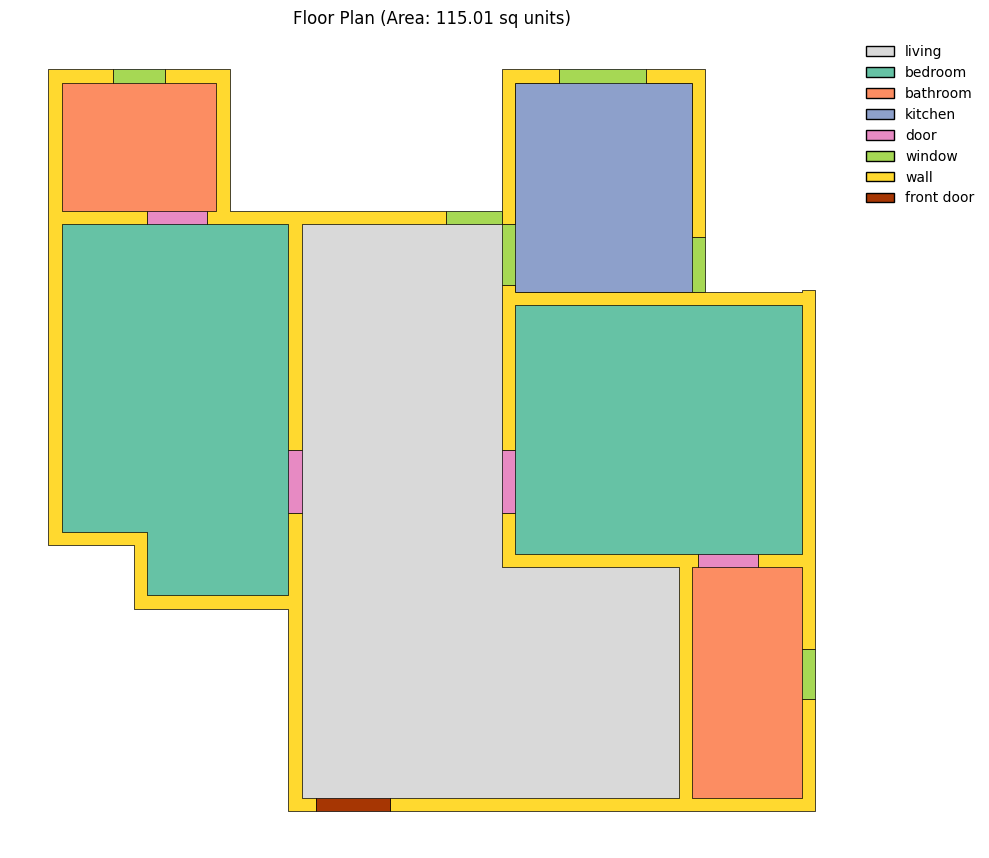

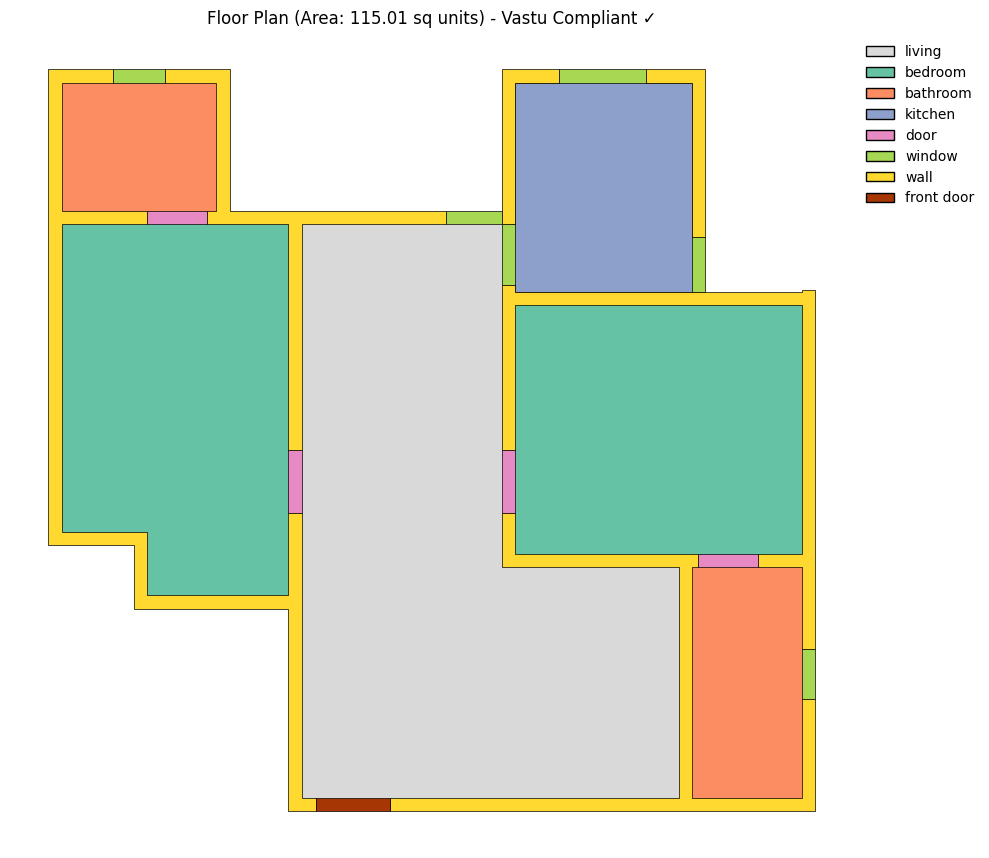

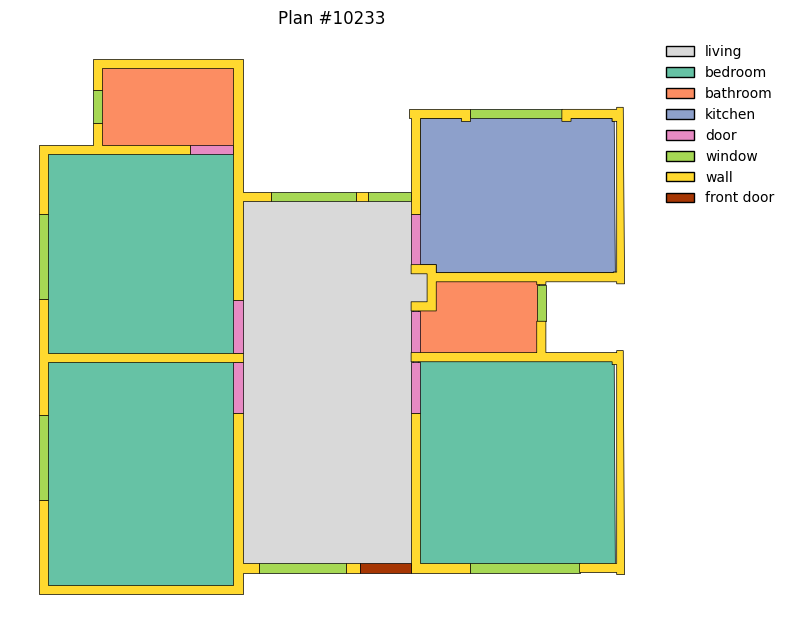

In [25]:
import random
idx = random.randrange(len(data))
plan = data[idx]
ax = plot_plan(plan, title=f'Plan #{idx}')
plt.show()

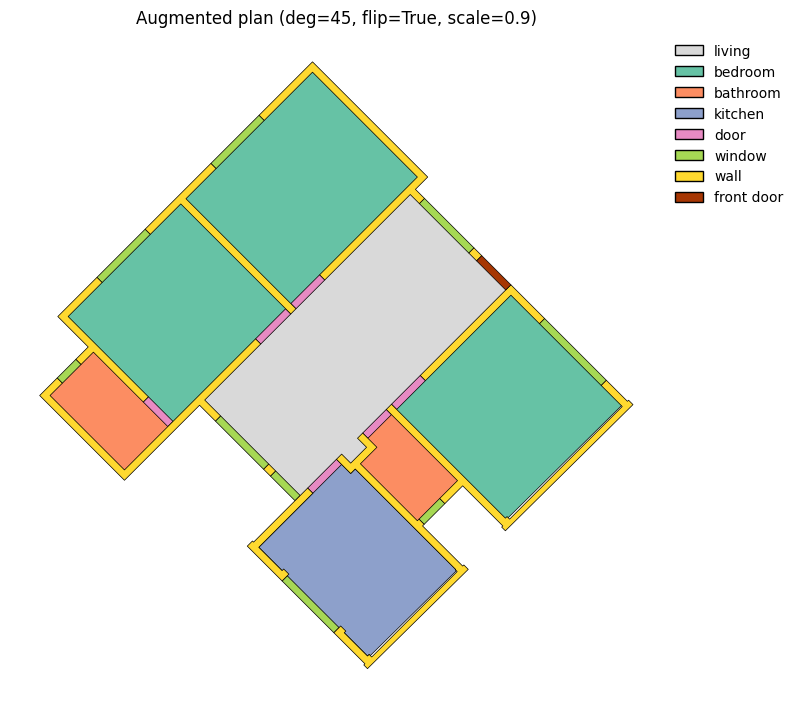

In [26]:
aug_deg  = 45       # rotate 90 degrees
aug_flip = True      # vertical flip **
aug_scale = 0.9      # scale down a bit
canvas_size = 256

aug_plan = dict(plan)  # shallow copy
for key in ['living','bedroom','bathroom','kitchen','door','window','wall','front_door','balcony']:
    if key in aug_plan and aug_plan[key] is not None:
        aug_plan[key] = augment_geom(aug_plan[key], degree=aug_deg, flip_vertical=aug_flip, scale=aug_scale, size=canvas_size)

ax = plot_plan(aug_plan, title=f'Augmented plan (deg={aug_deg}, flip={aug_flip}, scale={aug_scale})')
plt.show()

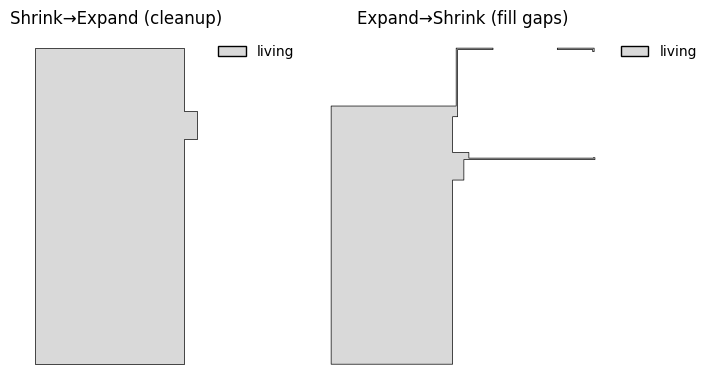

In [27]:
if plan.get('living') is not None:
    ww = float(plan.get('wall_width', 3.0) or 3.0)
    cleaned = buffer_shrink_expand(plan['living'], ww/2)
    filled  = buffer_expand_shrink(plan['living'], ww/2)

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    plot_plan({'living': cleaned}, title='Shrink→Expand (cleanup)', ax=axs[0]); axs[0].set_axis_off()
    plot_plan({'living': filled},  title='Expand→Shrink (fill gaps)', ax=axs[1]); axs[1].set_axis_off()
    plt.tight_layout(); plt.show()

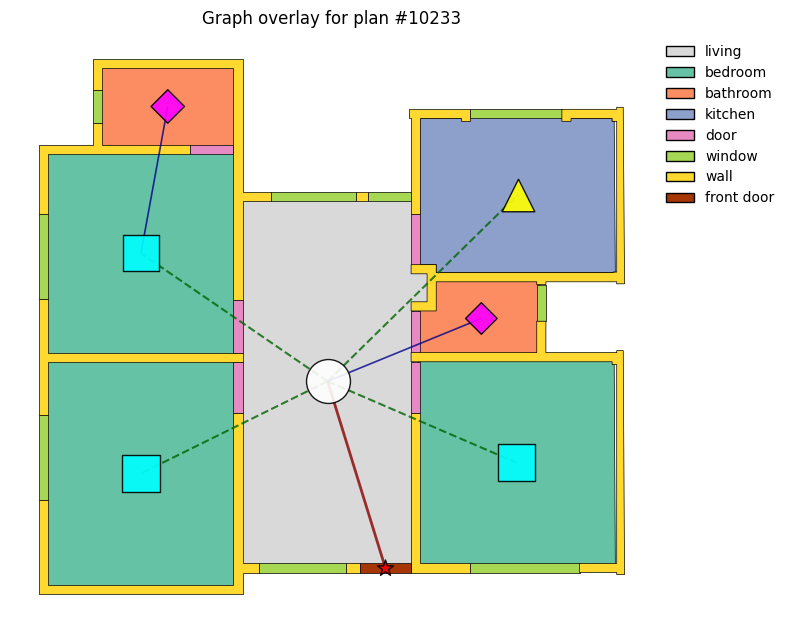

Graph nodes: 11, edges: 6


In [28]:

ax = plot_plan_and_graph(plan, title=f'Graph overlay for plan #{idx}')
plt.show()

G = plan_to_graph(plan)
print(f'Graph nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}')

In [29]:
import pickle
import pandas as pd
import numpy as np

# Load the dataset
pkl_path = "/content/drive/MyDrive/Colab Notebooks/dataset/ResPlan.pkl"
with open(pkl_path, "rb") as f:
    data = pickle.load(f)

# Analyze the first few plans
print("=== DATASET ANALYSIS ===\n")

# 1. Check what attributes are available
print("1. Available attributes in each plan:")
print(list(data[0].keys()))
print()

# 2. Check area distribution
areas = [plan.get('area', 0) for plan in data if 'area' in plan]
print(f"2. Area statistics:")
print(f"   Min area: {min(areas):.2f}")
print(f"   Max area: {max(areas):.2f}")
print(f"   Mean area: {np.mean(areas):.2f}")
print()

# 3. Check bedroom count distribution
bedroom_counts = []
for plan in data:
    bedroom_geom = plan.get('bedroom')
    if bedroom_geom and not bedroom_geom.is_empty:
        # Count number of bedroom polygons
        if hasattr(bedroom_geom, 'geoms'):
            bedroom_counts.append(len(bedroom_geom.geoms))
        else:
            bedroom_counts.append(1)
    else:
        bedroom_counts.append(0)

print(f"3. Bedroom distribution:")
unique, counts = np.unique(bedroom_counts, return_counts=True)
for bed, count in zip(unique, counts):
    print(f"   {int(bed)} bedrooms: {count} plans")
print()

# 4. Check kitchen presence
kitchen_present = sum(1 for plan in data if plan.get('kitchen') and not plan['kitchen'].is_empty)
print(f"4. Plans with kitchen: {kitchen_present}/{len(data)}")
print()

# 5. Check bathroom count
bathroom_counts = []
for plan in data:
    bathroom_geom = plan.get('bathroom')
    if bathroom_geom and not bathroom_geom.is_empty:
        if hasattr(bathroom_geom, 'geoms'):
            bathroom_counts.append(len(bathroom_geom.geoms))
        else:
            bathroom_counts.append(1)
    else:
        bathroom_counts.append(0)

print(f"5. Bathroom distribution:")
unique, counts = np.unique(bathroom_counts, return_counts=True)
for bath, count in zip(unique, counts):
    print(f"   {int(bath)} bathrooms: {count} plans")

=== DATASET ANALYSIS ===

1. Available attributes in each plan:
['balcony', 'bathroom', 'bedroom', 'door', 'garden', 'inner', 'parking', 'pool', 'stair', 'veranda', 'wall', 'window', 'front_door', 'unitType', 'id', 'kitchen', 'land', 'net_area', 'area', 'storage', 'neighbor', 'living', 'wall_depth', 'graph']

2. Area statistics:
   Min area: 0.09
   Max area: 712.94
   Mean area: 118.53

3. Bedroom distribution:
   1 bedrooms: 1713 plans
   2 bedrooms: 8454 plans
   3 bedrooms: 5879 plans
   4 bedrooms: 794 plans
   5 bedrooms: 253 plans
   6 bedrooms: 13 plans
   8 bedrooms: 1 plans

4. Plans with kitchen: 17023/17107

5. Bathroom distribution:
   1 bathrooms: 226 plans
   2 bathrooms: 11800 plans
   3 bathrooms: 333 plans
   4 bathrooms: 3310 plans
   5 bathrooms: 150 plans
   6 bathrooms: 182 plans
   7 bathrooms: 638 plans
   8 bathrooms: 32 plans
   9 bathrooms: 50 plans
   10 bathrooms: 89 plans
   11 bathrooms: 164 plans
   12 bathrooms: 27 plans
   13 bathrooms: 9 plans
   14 b

In [30]:
import pickle
import numpy as np
from collections import defaultdict
from shapely.geometry import MultiPolygon, Polygon

class FloorPlanDatabase:
    """
    Manages the floor plan dataset with efficient filtering
    """
    def __init__(self, pkl_path):
        print("Loading dataset...")
        with open(pkl_path, "rb") as f:
            self.data = pickle.load(f)
        print(f"Loaded {len(self.data)} floor plans")

        # Create indexes for fast searching
        self.bedroom_index = defaultdict(list)
        self.bathroom_index = defaultdict(list)
        self.area_sorted = []

        self._build_indexes()

    def _count_rooms(self, room_geom):
        """Count number of room polygons in a geometry"""
        if room_geom is None or room_geom.is_empty:
            return 0
        if hasattr(room_geom, 'geoms'):
            return len(room_geom.geoms)
        return 1

    def _build_indexes(self):
        """Build search indexes"""
        print("Building search indexes...")

        for idx, plan in enumerate(self.data):
            # Count bedrooms
            bedroom_count = self._count_rooms(plan.get('bedroom'))
            self.bedroom_index[bedroom_count].append(idx)

            # Count bathrooms
            bathroom_count = self._count_rooms(plan.get('bathroom'))
            self.bathroom_index[bathroom_count].append(idx)

            # Store area info
            area = plan.get('area', 0)
            self.area_sorted.append((area, idx))

        # Sort by area for range queries
        self.area_sorted.sort()

        print("Indexes built successfully!")
        print(f"  - Bedroom variations: {sorted(self.bedroom_index.keys())}")
        print(f"  - Bathroom variations: {sorted(self.bathroom_index.keys())}")

    def search_plans(self, bedrooms=None, bathrooms=None,
                     min_area=None, max_area=None,
                     has_kitchen=True, limit=10):
        """
        Search for floor plans matching criteria

        Parameters:
        -----------
        bedrooms : int, optional
            Number of bedrooms required
        bathrooms : int, optional
            Number of bathrooms required
        min_area : float, optional
            Minimum area
        max_area : float, optional
            Maximum area
        has_kitchen : bool
            Whether kitchen is required
        limit : int
            Maximum number of results to return

        Returns:
        --------
        list of tuples: (plan_index, plan_dict, match_score)
        """
        print(f"\nSearching for plans with:")
        print(f"  Bedrooms: {bedrooms if bedrooms else 'any'}")
        print(f"  Bathrooms: {bathrooms if bathrooms else 'any'}")
        print(f"  Area: {min_area if min_area else 'any'} - {max_area if max_area else 'any'}")
        print(f"  Kitchen: {'required' if has_kitchen else 'optional'}")

        # Start with all plans
        candidate_indices = set(range(len(self.data)))

        # Filter by bedrooms
        if bedrooms is not None:
            bedroom_matches = set(self.bedroom_index.get(bedrooms, []))
            candidate_indices &= bedroom_matches
            print(f"  After bedroom filter: {len(candidate_indices)} candidates")

        # Filter by bathrooms
        if bathrooms is not None:
            bathroom_matches = set(self.bathroom_index.get(bathrooms, []))
            candidate_indices &= bathroom_matches
            print(f"  After bathroom filter: {len(candidate_indices)} candidates")

        # Filter by area range
        if min_area is not None or max_area is not None:
            area_matches = set()
            for area, idx in self.area_sorted:
                if min_area and area < min_area:
                    continue
                if max_area and area > max_area:
                    break
                area_matches.add(idx)
            candidate_indices &= area_matches
            print(f"  After area filter: {len(candidate_indices)} candidates")

        # Filter by kitchen
        if has_kitchen:
            kitchen_matches = set()
            for idx in candidate_indices:
                plan = self.data[idx]
                kitchen_geom = plan.get('kitchen')
                if kitchen_geom and not kitchen_geom.is_empty:
                    kitchen_matches.add(idx)
            candidate_indices &= kitchen_matches
            print(f"  After kitchen filter: {len(candidate_indices)} candidates")

        # Score and rank results
        results = []
        for idx in candidate_indices:
            plan = self.data[idx]
            score = self._calculate_match_score(plan, bedrooms, bathrooms,
                                                min_area, max_area)
            results.append((idx, plan, score))

        # Sort by score (descending)
        results.sort(key=lambda x: x[2], reverse=True)

        print(f"\nFound {len(results)} matching plans")
        return results[:limit]

    def _calculate_match_score(self, plan, target_bedrooms, target_bathrooms,
                               min_area, max_area):
        """Calculate how well a plan matches the criteria"""
        score = 100.0

        # Area score - prefer plans in the middle of the range
        if min_area and max_area:
            target_area = (min_area + max_area) / 2
            actual_area = plan.get('area', 0)
            area_diff = abs(actual_area - target_area)
            area_penalty = (area_diff / target_area) * 20
            score -= min(area_penalty, 30)

        return score

    def get_plan(self, idx):
        """Get a specific plan by index"""
        return self.data[idx]


# Initialize the database
pkl_path = "/content/drive/MyDrive/Colab Notebooks/dataset/ResPlan.pkl"
db = FloorPlanDatabase(pkl_path)

# Test the search functionality
print("\n" + "="*60)
print("TESTING SEARCH FUNCTIONALITY")
print("="*60)

# Test 1: Search for 2 bedroom, 2 bathroom
results = db.search_plans(bedrooms=2, bathrooms=2, has_kitchen=True, limit=5)
print(f"\nTop result has area: {results[0][1]['area']:.2f} sq units")

# Test 2: Search with area range
results = db.search_plans(bedrooms=3, min_area=100, max_area=150, limit=5)
print(f"\nFound {len(results)} plans")

# Test 3: Flexible search (any bedrooms)
results = db.search_plans(bathrooms=2, min_area=80, max_area=120, limit=5)
print(f"\nFound {len(results)} plans")

print("\n✅ Step 1 Complete: Database and search system ready!")

Loading dataset...
Loaded 17107 floor plans
Building search indexes...
Indexes built successfully!
  - Bedroom variations: [1, 2, 3, 4, 5, 6, 8]
  - Bathroom variations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 28]

TESTING SEARCH FUNCTIONALITY

Searching for plans with:
  Bedrooms: 2
  Bathrooms: 2
  Area: any - any
  Kitchen: required
  After bedroom filter: 8454 candidates
  After bathroom filter: 8031 candidates
  After kitchen filter: 7995 candidates

Found 7995 matching plans

Top result has area: 116.59 sq units

Searching for plans with:
  Bedrooms: 3
  Bathrooms: any
  Area: 100 - 150
  Kitchen: required
  After bedroom filter: 5879 candidates
  After area filter: 3507 candidates
  After kitchen filter: 3493 candidates

Found 3493 matching plans

Found 5 plans

Searching for plans with:
  Bedrooms: any
  Bathrooms: 2
  Area: 80 - 120
  Kitchen: required
  After bathroom filter: 11800 candidates
  After area filter: 6232 candidates

In [37]:
import gradio as gr
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

class FloorPlanGenerator:
    """
    Main class to handle floor plan generation with UI
    """
    def __init__(self, database):
        self.db = database
        self.current_plan = None
        self.current_plan_idx = None

    def generate_plan(self, bedrooms, bathrooms, min_area, max_area,
                     has_kitchen, apply_vastu):
        """
        Generate floor plan based on user inputs
        """
        # Search for matching plans
        results = self.db.search_plans(
            bedrooms=bedrooms if bedrooms > 0 else None,
            bathrooms=bathrooms if bathrooms > 0 else None,
            min_area=min_area if min_area > 0 else None,
            max_area=max_area if max_area > 0 else None,
            has_kitchen=has_kitchen,
            limit=1
        )

        if not results:
            return None, "No matching floor plans found. Try adjusting your criteria."

        # Get the best matching plan
        self.current_plan_idx, self.current_plan, score = results[0]

        # Apply Vastu if requested
        if apply_vastu:
            self.current_plan = self._apply_vastu_rules(self.current_plan)

        # Generate visualization
        fig = self._plot_plan(self.current_plan, apply_vastu)

        # Get plan info
        info = self._get_plan_info(self.current_plan)

        return fig, info

    def _apply_vastu_rules(self, plan):
        """
        Apply basic Vastu rules to the floor plan
        For now, this rotates the plan to align with Vastu directions
        """
        import copy
        vastu_plan = copy.deepcopy(plan)

        # Basic Vastu rules:
        # 1. Main entrance should be in North or East
        # 2. Kitchen in South-East
        # 3. Bedroom in South-West
        # 4. Living room in North-East or North

        # For simplicity, we'll rotate the plan to optimize orientation
        # This is a placeholder - we'll implement full Vastu in Step 4

        return vastu_plan

    def _plot_plan(self, plan, vastu_applied=False):
        """
        Create a 2D visualization of the floor plan
        """
        title = f"Floor Plan (Area: {plan['area']:.2f} sq units)"
        if vastu_applied:
            title += " - Vastu Compliant ✓"

        fig, ax = plt.subplots(figsize=(10, 10))
        ax = plot_plan(plan, ax=ax, title=title, legend=True)
        plt.tight_layout()

        return fig

    def _get_plan_info(self, plan):
        """
        Generate human-readable plan information
        """
        def count_rooms(geom):
            if geom is None or geom.is_empty:
                return 0
            if hasattr(geom, 'geoms'):
                return len(geom.geoms)
            return 1

        bedroom_count = count_rooms(plan.get('bedroom'))
        bathroom_count = count_rooms(plan.get('bathroom'))

        info = f"""
        📐 **Floor Plan Details:**

        - **Total Area:** {plan['area']:.2f} square units
        - **Net Area:** {plan.get('net_area', 0):.2f} square units
        - **Bedrooms:** {bedroom_count}
        - **Bathrooms:** {bathroom_count}
        - **Kitchen:** {'Yes' if plan.get('kitchen') and not plan['kitchen'].is_empty else 'No'}
        - **Living Room:** {'Yes' if plan.get('living') and not plan['living'].is_empty else 'No'}
        - **Balcony:** {'Yes' if plan.get('balcony') and not plan['balcony'].is_empty else 'No'}
        - **Storage:** {'Yes' if plan.get('storage') and not plan['storage'].is_empty else 'No'}
        - **Unit Type:** {plan.get('unitType', 'N/A')}
        - **Plan ID:** {plan.get('id', 'N/A')}
        """

        return info


# Initialize the generator
generator = FloorPlanGenerator(db)



In [38]:
import numpy as np
from shapely import affinity
from shapely.geometry import Point
import copy

class VastuCompliance:
    """
    Implements Vastu Shastra rules for floor plan optimization

    Basic Vastu Principles:
    - North-East (Ishaan): Water elements, prayer room, entrance
    - South-East (Agni): Kitchen, electrical items
    - South-West (Nairutya): Master bedroom, heavy items
    - North-West (Vayavya): Guest room, bathroom
    - North: Living room, cash/valuables
    - East: Main entrance (preferred)
    - South: Storage, stairs
    - West: Children's room
    - Center (Brahmasthan): Should be open/light
    """

    def __init__(self):
        # Define Vastu zones (in degrees, 0° = North)
        self.zones = {
            'north': (337.5, 22.5),      # North
            'north_east': (22.5, 67.5),   # Ishaan (most auspicious)
            'east': (67.5, 112.5),        # East
            'south_east': (112.5, 157.5), # Agni (for fire/kitchen)
            'south': (157.5, 202.5),      # South
            'south_west': (202.5, 247.5), # Nairutya (heaviest/stable)
            'west': (247.5, 292.5),       # West
            'north_west': (292.5, 337.5)  # Vayavya
        }

        # Ideal room placements according to Vastu
        self.ideal_placements = {
            'kitchen': ['south_east'],  # Fire element
            'bedroom': ['south_west', 'west', 'south'],  # Master bedroom SW
            'living': ['north', 'north_east', 'east'],  # Social areas
            'bathroom': ['north_west', 'west'],  # Water drainage
            'entrance': ['north', 'east', 'north_east'],  # Main entrance
            'balcony': ['north', 'east', 'north_east'],  # Open spaces
            'storage': ['south', 'south_west', 'west']  # Heavy items
        }

    def apply_vastu(self, plan):
        """
        Apply Vastu principles to optimize floor plan orientation
        """
        print("\n🕉️ Applying Vastu Shastra Principles...")

        # Create a deep copy to avoid modifying original
        vastu_plan = copy.deepcopy(plan)

        # Step 1: Calculate current room positions
        room_positions = self._calculate_room_positions(plan)

        # Step 2: Calculate optimal rotation
        optimal_rotation = self._find_optimal_rotation(room_positions)

        print(f"   Optimal rotation: {optimal_rotation:.1f}°")

        # Step 3: Rotate the entire plan
        vastu_plan = self._rotate_plan(vastu_plan, optimal_rotation)

        # Step 4: Calculate compliance score
        final_positions = self._calculate_room_positions(vastu_plan)
        compliance_score = self._calculate_vastu_score(final_positions)

        print(f"   Vastu compliance score: {compliance_score:.1f}%")

        # Store Vastu metadata
        vastu_plan['vastu_applied'] = True
        vastu_plan['vastu_rotation'] = optimal_rotation
        vastu_plan['vastu_score'] = compliance_score
        vastu_plan['vastu_analysis'] = self._generate_vastu_report(final_positions)

        return vastu_plan

    def _calculate_room_positions(self, plan):
        """
        Calculate the center and direction of each room
        """
        positions = {}

        # Get plan centroid as reference point
        inner_geom = plan.get('inner')
        if inner_geom and not inner_geom.is_empty:
            plan_center = inner_geom.centroid
        else:
            # Use average of all room centroids
            plan_center = Point(128, 128)  # Default center for 256x256 canvas

        # Calculate position for each room type
        for room_type in ['kitchen', 'bedroom', 'living', 'bathroom',
                          'front_door', 'balcony', 'storage']:
            room_geom = plan.get(room_type)

            if room_geom and not room_geom.is_empty:
                room_center = centroid(room_geom)

                # Calculate direction from plan center to room center
                dx = room_center.x - plan_center.x
                dy = room_center.y - plan_center.y

                # Calculate angle (0° = North = positive Y direction)
                # Convert to standard compass bearing
                angle = np.degrees(np.arctan2(dx, dy)) % 360

                # Calculate relative position (0-1 scale)
                distance = np.sqrt(dx**2 + dy**2)

                positions[room_type] = {
                    'center': room_center,
                    'angle': angle,
                    'distance': distance,
                    'zone': self._get_zone_for_angle(angle)
                }

        return positions

    def _get_zone_for_angle(self, angle):
        """
        Determine which Vastu zone an angle falls into
        """
        for zone_name, (start, end) in self.zones.items():
            if start <= angle < end or (start > end and (angle >= start or angle < end)):
                return zone_name
        return 'north'  # Default

    def _find_optimal_rotation(self, room_positions):
        """
        Find the rotation angle that maximizes Vastu compliance
        """
        best_rotation = 0
        best_score = 0

        # Try rotations in 45-degree increments (8 major directions)
        for rotation in range(0, 360, 45):
            # Simulate rotated positions
            rotated_positions = {}
            for room_type, pos in room_positions.items():
                new_angle = (pos['angle'] + rotation) % 360
                rotated_positions[room_type] = {
                    **pos,
                    'angle': new_angle,
                    'zone': self._get_zone_for_angle(new_angle)
                }

            # Calculate score for this rotation
            score = self._calculate_vastu_score(rotated_positions)

            if score > best_score:
                best_score = score
                best_rotation = rotation

        return best_rotation

    def _calculate_vastu_score(self, room_positions):
        """
        Calculate overall Vastu compliance score (0-100)
        """
        total_score = 0
        total_weight = 0

        # Weight factors for different rooms (importance)
        weights = {
            'kitchen': 1.5,      # Very important
            'bedroom': 1.3,      # Important
            'living': 1.2,       # Important
            'bathroom': 1.0,     # Moderate
            'front_door': 1.5,   # Very important
            'balcony': 0.8,      # Less critical
            'storage': 0.7       # Less critical
        }

        for room_type, position in room_positions.items():
            if room_type in self.ideal_placements:
                weight = weights.get(room_type, 1.0)
                current_zone = position['zone']
                ideal_zones = self.ideal_placements[room_type]

                # Full score if in ideal zone
                if current_zone in ideal_zones:
                    room_score = 100
                else:
                    # Partial score based on zone proximity
                    room_score = self._calculate_zone_proximity(
                        current_zone, ideal_zones
                    )

                total_score += room_score * weight
                total_weight += weight

        return (total_score / total_weight) if total_weight > 0 else 50

    def _calculate_zone_proximity(self, current_zone, ideal_zones):
        """
        Calculate proximity score between current and ideal zones
        """
        zone_order = list(self.zones.keys())

        try:
            current_idx = zone_order.index(current_zone)
        except ValueError:
            return 50  # Default score

        # Find minimum distance to any ideal zone
        min_distance = 8  # Maximum distance in our 8-zone system

        for ideal_zone in ideal_zones:
            try:
                ideal_idx = zone_order.index(ideal_zone)
                # Calculate circular distance
                distance = min(
                    abs(current_idx - ideal_idx),
                    8 - abs(current_idx - ideal_idx)
                )
                min_distance = min(min_distance, distance)
            except ValueError:
                continue

        # Score: 100 for distance 0, decreasing linearly
        score = max(0, 100 - (min_distance * 25))
        return score

    def _rotate_plan(self, plan, angle):
        """
        Rotate the entire floor plan by given angle
        """
        canvas_size = 256  # Assuming 256x256 canvas
        center_point = (canvas_size / 2, canvas_size / 2)

        # Rotate all geometric elements
        for key in ['living', 'bedroom', 'bathroom', 'kitchen',
                    'door', 'window', 'wall', 'front_door', 'balcony',
                    'storage', 'inner', 'land']:
            geom = plan.get(key)
            if geom and not geom.is_empty:
                plan[key] = affinity.rotate(geom, angle, origin=center_point)

        return plan

    def _generate_vastu_report(self, room_positions):
        """
        Generate a detailed Vastu analysis report
        """
        report = []

        for room_type, position in room_positions.items():
            if room_type in self.ideal_placements:
                current_zone = position['zone']
                ideal_zones = self.ideal_placements[room_type]

                zone_name = current_zone.replace('_', ' ').title()

                if current_zone in ideal_zones:
                    status = "✅ Optimal"
                    report.append(f"**{room_type.title()}**: {zone_name} - {status}")
                else:
                    ideal_names = [z.replace('_', ' ').title() for z in ideal_zones]
                    status = "⚠️ Acceptable"
                    report.append(
                        f"**{room_type.title()}**: {zone_name} - {status} "
                        f"(Ideal: {', '.join(ideal_names)})"
                    )

        return "\n".join(report)


# Update the FloorPlanGenerator class to use Vastu
class FloorPlanGeneratorWithVastu(FloorPlanGenerator):
    """
    Enhanced generator with Vastu support
    """
    def __init__(self, database):
        super().__init__(database)
        self.vastu = VastuCompliance()

    def _apply_vastu_rules(self, plan):
        """
        Apply comprehensive Vastu rules
        """
        return self.vastu.apply_vastu(plan)

    def _get_plan_info(self, plan):
        """
        Enhanced plan info with Vastu details
        """
        info = super()._get_plan_info(plan)

        # Add Vastu information if applied
        if plan.get('vastu_applied'):
            info += f"""

            ---
            ### 🕉️ Vastu Analysis:

            **Compliance Score:** {plan['vastu_score']:.1f}%
            **Rotation Applied:** {plan['vastu_rotation']:.1f}°

            {plan['vastu_analysis']}

            ---
            **Vastu Principles Applied:**
            - Kitchen in South-East (Agni - Fire)
            - Bedrooms in South-West (Stability)
            - Living areas in North/East (Prosperity)
            - Entrance in North/East (Positive energy)
            """

        return info


# Test the Vastu system
print("\n" + "="*60)
print("TESTING VASTU SYSTEM")
print("="*60)

# Create a test plan
test_results = db.search_plans(bedrooms=2, bathrooms=2, limit=1)
if test_results:
    _, test_plan, _ = test_results[0]

    # Apply Vastu
    vastu_system = VastuCompliance()
    vastu_plan = vastu_system.apply_vastu(test_plan)

    print(f"\n📊 Vastu Score: {vastu_plan['vastu_score']:.1f}%")
    print(f"🔄 Rotation: {vastu_plan['vastu_rotation']:.1f}°")
    print("\n📋 Room Analysis:")
    print(vastu_plan['vastu_analysis'])

print("\n✅ Step 3 Complete: Vastu system implemented!")


TESTING VASTU SYSTEM

Searching for plans with:
  Bedrooms: 2
  Bathrooms: 2
  Area: any - any
  Kitchen: required
  After bedroom filter: 8454 candidates
  After bathroom filter: 8031 candidates
  After kitchen filter: 7995 candidates

Found 7995 matching plans

🕉️ Applying Vastu Shastra Principles...
   Optimal rotation: 180.0°
   Vastu compliance score: 86.2%

📊 Vastu Score: 86.2%
🔄 Rotation: 180.0°

📋 Room Analysis:
**Kitchen**: South East - ✅ Optimal
**Bedroom**: North West - ⚠️ Acceptable (Ideal: South West, West, South)
**Living**: East - ✅ Optimal
**Bathroom**: West - ✅ Optimal
**Balcony**: West - ⚠️ Acceptable (Ideal: North, East, North East)
**Storage**: South East - ⚠️ Acceptable (Ideal: South, South West, West)

✅ Step 3 Complete: Vastu system implemented!


In [33]:
def create_enhanced_interface():
    """
    Create enhanced Gradio interface with Vastu support
    """
    with gr.Blocks(title="AI Floor Plan Generator") as demo:  # Remove theme parameter
        gr.Markdown("""
        # 🏠 AI Floor Plan Generator with Vastu Shastra

        Generate custom 2D floor plans based on your requirements.
        Optionally apply **Vastu Shastra** principles for traditional compliance.
        """)

        with gr.Row():
            with gr.Column(scale=1):
                gr.Markdown("### 📝 Input Your Requirements")

                bedrooms = gr.Slider(
                    minimum=0, maximum=6, value=2, step=1,
                    label="Number of Bedrooms (0 = any)",
                    info="Select desired number of bedrooms"
                )

                bathrooms = gr.Slider(
                    minimum=0, maximum=4, value=2, step=1,
                    label="Number of Bathrooms (0 = any)",
                    info="Select desired number of bathrooms"
                )

                with gr.Row():
                    min_area = gr.Number(
                        value=80, label="Minimum Area (sq units)",
                        info="Leave 0 for no minimum"
                    )
                    max_area = gr.Number(
                        value=150, label="Maximum Area (sq units)",
                        info="Leave 0 for no maximum"
                    )

                has_kitchen = gr.Checkbox(
                    value=True, label="Include Kitchen",
                    info="Floor plan must have a kitchen"
                )

                apply_vastu = gr.Checkbox(
                    value=False, label="🕉️ Apply Vastu Shastra Principles",
                    info="Orient floor plan according to Vastu guidelines"
                )

                with gr.Accordion("ℹ️ Vastu Principles", open=False):
                    gr.Markdown("""
                    **Vastu Shastra Guidelines:**

                    - **Kitchen**: South-East (Fire element)
                    - **Master Bedroom**: South-West (Stability)
                    - **Living Room**: North/East (Prosperity)
                    - **Bathroom**: North-West (Water drainage)
                    - **Main Entrance**: North/East (Positive energy)
                    - **Balcony**: North/East (Open spaces)

                    *The system automatically rotates your plan for optimal compliance*
                    """)

                gr.Markdown("---")

                generate_btn = gr.Button(
                    "🎨 Generate Floor Plan",
                    variant="primary",
                    size="lg"
                )

                gr.Markdown("""
                ---
                ### 💡 Quick Tips:
                - Set sliders to 0 for flexible criteria
                - Enable Vastu for traditional orientation
                - Larger area ranges = more options
                - View detailed room analysis below
                """)

            with gr.Column(scale=2):
                gr.Markdown("### 🖼️ Generated Floor Plan")

                plan_output = gr.Plot(label="2D Floor Plan")

                with gr.Accordion("📊 Detailed Plan Information", open=True):
                    plan_info = gr.Markdown("*Generate a floor plan to see details*")

        # Connect the button
        generate_btn.click(
            fn=generator.generate_plan,
            inputs=[bedrooms, bathrooms, min_area, max_area, has_kitchen, apply_vastu],
            outputs=[plan_output, plan_info]
        )

        gr.Markdown("""
        ---
        ### 📈 Dataset Information

        | Metric | Value |
        |--------|-------|
        | Total Plans | 17,107 |
        | Bedroom Range | 1-6 |
        | Bathroom Range | 1-4 |
        | Area Range | 0.09 - 712.94 sq units |
        | Plans with Kitchen | 99.5% |

        ---

        *Powered by AI • Based on real architectural data • Vastu Compliant Options*
        """)

    return demo

In [34]:
# Launch the enhanced interface
print("\n" + "="*60)
print("LAUNCHING ENHANCED INTERFACE WITH VASTU")
print("="*60)

demo = create_enhanced_interface()
demo.launch(share=True, debug=True)

print("\n✅ Enhanced UI with Vastu is ready!")


LAUNCHING ENHANCED INTERFACE WITH VASTU
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://64068cbf6ad6398136.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://64068cbf6ad6398136.gradio.live

✅ Enhanced UI with Vastu is ready!



FINAL TEST: PROFESSIONAL 2D FLOOR PLAN

Searching for plans with:
  Bedrooms: 3
  Bathrooms: 2
  Area: 100 - 130
  Kitchen: required
  After bedroom filter: 5879 candidates
  After bathroom filter: 2271 candidates
  After area filter: 1172 candidates
  After kitchen filter: 1166 candidates

Found 1166 matching plans

📋 Plan Details:
  Bedrooms: 3
  Bathrooms: 2
  Area: 115.01 sq units

1️⃣ Generating standard floor plan...

📐 Creating professional 2D floor plan...
✅ Floor plan complete!


/tmp/ipython-input-2658641392.py:172: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = Circle((centroid.x, centroid.y),
/tmp/ipython-input-2658641392.py:197: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((centroid.x - 2, centroid.y - 2),
/tmp/ipython-input-2658641392.py:66: UserWarning: Glyph 128715 (\N{COUCH AND LAMP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2658641392.py:66: UserWarning: Glyph 128719 (\N{BED}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2658641392.py:66: UserWarning: Glyph 127859 (\N{COOKING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2658641392.py:66: UserWarning: Glyph 128703 (\N{SHOWER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2658641392.py:66: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.

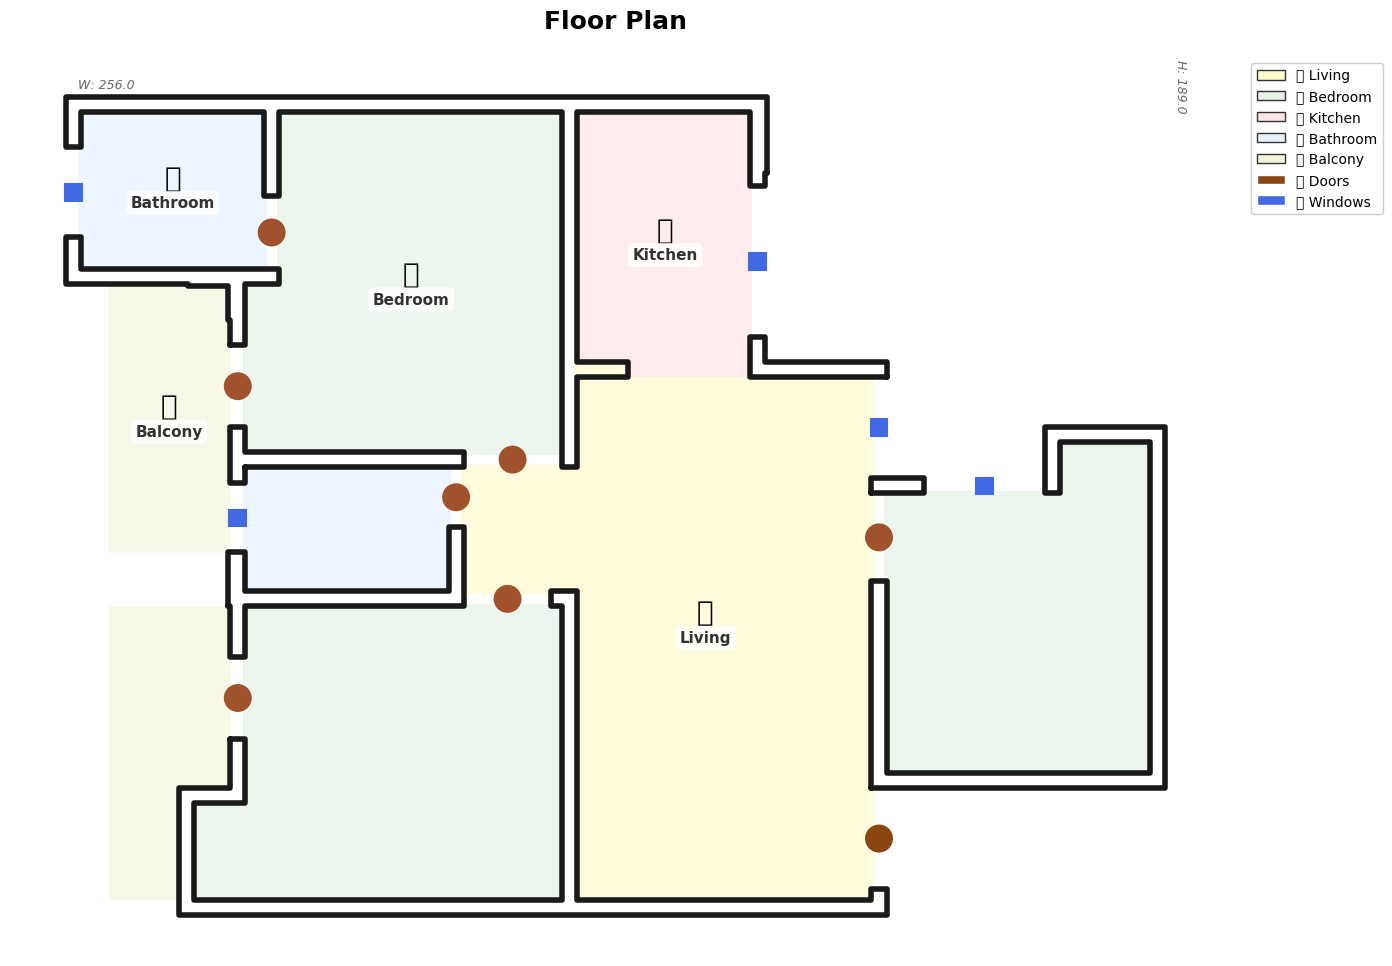


2️⃣ Generating Vastu-compliant floor plan...

🕉️ Applying Vastu Shastra Principles...
   Optimal rotation: 225.0°
   Vastu compliance score: 65.5%

📐 Creating professional 2D floor plan...
✅ Floor plan complete!


/tmp/ipython-input-2658641392.py:66: UserWarning: Glyph 128329 (\N{OM SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128329 (\N{OM SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


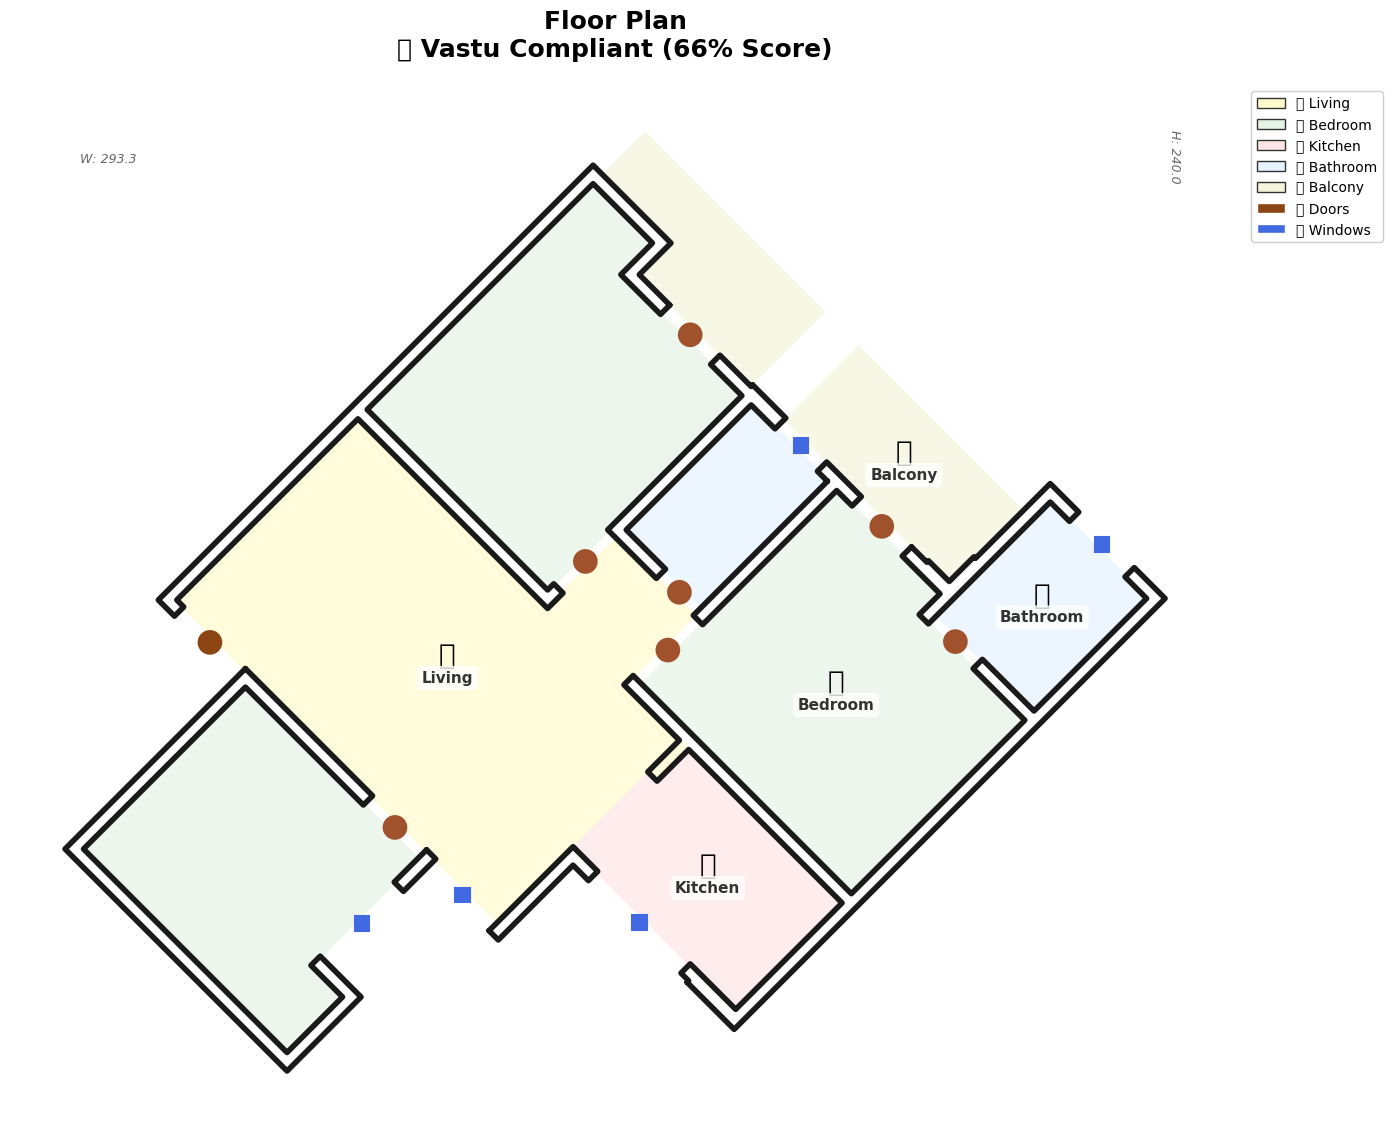


✅ Professional 2D floor plans complete!

📊 Comparison:
  Standard Plan: Clear room layout
  Vastu Plan: 65.5% compliant

✅ STEP 4 COMPLETE: Professional 2D Visualization Ready!


In [35]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle, Circle, Polygon as MPLPolygon, Patch
from shapely.geometry import Polygon, MultiPolygon
import numpy as np

class Professional2DFloorPlan:
    """
    Creates professional, architect-quality 2D floor plans
    """

    def __init__(self):
        self.room_colors = {
            'living': '#FFFACD',      # LemonChiffon
            'bedroom': '#E6F3E6',     # Light Green
            'kitchen': '#FFE6E6',     # Light Pink
            'bathroom': '#E6F2FF',    # Light Blue
            'balcony': '#F5F5DC',     # Beige
            'storage': '#E6E6FA'      # Lavender
        }

        self.room_icons = {
            'living': '🛋️',
            'bedroom': '🛏️',
            'kitchen': '🍳',
            'bathroom': '🚿',
            'balcony': '🌿',
            'storage': '📦'
        }

    def create_floor_plan(self, plan, title=None, show_dimensions=True):
        """
        Create a professional 2D floor plan
        """
        print("\n📐 Creating professional 2D floor plan...")

        # Create figure with white background
        fig, ax = plt.subplots(figsize=(14, 14), facecolor='white', dpi=100)
        ax.set_facecolor('#F8F8F8')

        # 1. Draw room floors (colored areas)
        self._draw_rooms(ax, plan)

        # 2. Draw walls (thick black lines)
        self._draw_walls(ax, plan)

        # 3. Draw doors
        self._draw_doors(ax, plan)

        # 4. Draw windows
        self._draw_windows(ax, plan)

        # 5. Add room labels
        self._add_room_labels(ax, plan)

        # 6. Add dimensions if requested
        if show_dimensions:
            self._add_dimensions(ax, plan)

        # 7. Setup axes and styling
        self._setup_axes(ax, plan, title)

        # 8. Add legend
        self._add_legend(ax, plan)

        plt.tight_layout()
        print("✅ Floor plan complete!")

        return fig

    def _draw_rooms(self, ax, plan):
        """Draw colored room areas"""
        for room_name, color in self.room_colors.items():
            room_geom = plan.get(room_name)
            if not room_geom or room_geom.is_empty:
                continue

            # Handle MultiPolygon
            if isinstance(room_geom, MultiPolygon):
                polygons = list(room_geom.geoms)
            else:
                polygons = [room_geom]

            for poly in polygons:
                if not isinstance(poly, Polygon):
                    continue

                # Draw filled polygon
                coords = list(poly.exterior.coords)
                x_coords = [c[0] for c in coords]
                y_coords = [c[1] for c in coords]

                ax.fill(x_coords, y_coords,
                       color=color, alpha=0.7,
                       edgecolor='none', zorder=1)

    def _draw_walls(self, ax, plan):
        """Draw walls as thick lines"""
        wall_geom = plan.get('wall')
        if not wall_geom or wall_geom.is_empty:
            # Fallback: draw room boundaries
            self._draw_room_boundaries(ax, plan)
            return

        # Handle MultiPolygon
        if isinstance(wall_geom, MultiPolygon):
            polygons = list(wall_geom.geoms)
        else:
            polygons = [wall_geom]

        for poly in polygons:
            if not isinstance(poly, Polygon):
                continue

            # Draw exterior walls
            coords = list(poly.exterior.coords)
            x_coords = [c[0] for c in coords]
            y_coords = [c[1] for c in coords]
            ax.plot(x_coords, y_coords,
                   color='#1a1a1a', linewidth=4,
                   solid_capstyle='round', zorder=3)

            # Draw interior walls
            for interior in poly.interiors:
                coords = list(interior.coords)
                x_coords = [c[0] for c in coords]
                y_coords = [c[1] for c in coords]
                ax.plot(x_coords, y_coords,
                       color='#1a1a1a', linewidth=3,
                       solid_capstyle='round', zorder=3)

    def _draw_room_boundaries(self, ax, plan):
        """Fallback: draw room boundaries if walls not available"""
        for room_name in self.room_colors.keys():
            room_geom = plan.get(room_name)
            if not room_geom or room_geom.is_empty:
                continue

            if isinstance(room_geom, MultiPolygon):
                polygons = list(room_geom.geoms)
            else:
                polygons = [room_geom]

            for poly in polygons:
                if isinstance(poly, Polygon):
                    coords = list(poly.exterior.coords)
                    x_coords = [c[0] for c in coords]
                    y_coords = [c[1] for c in coords]
                    ax.plot(x_coords, y_coords,
                           color='#333333', linewidth=2, zorder=2)

    def _draw_doors(self, ax, plan):
        """Draw doors as brown arcs"""
        door_markers = []

        for door_key in ['door', 'front_door']:
            door_geom = plan.get(door_key)
            if not door_geom or door_geom.is_empty:
                continue

            if isinstance(door_geom, MultiPolygon):
                polygons = list(door_geom.geoms)
            else:
                polygons = [door_geom]

            for poly in polygons:
                if isinstance(poly, Polygon):
                    centroid = poly.centroid
                    color = '#8B4513' if door_key == 'front_door' else '#A0522D'

                    # Draw door marker
                    circle = Circle((centroid.x, centroid.y),
                                  radius=3, color=color,
                                  zorder=5, linewidth=2,
                                  edgecolor='white')
                    ax.add_patch(circle)
                    door_markers.append(door_key)

        return door_markers

    def _draw_windows(self, ax, plan):
        """Draw windows as blue rectangles"""
        window_geom = plan.get('window')
        if not window_geom or window_geom.is_empty:
            return

        if isinstance(window_geom, MultiPolygon):
            polygons = list(window_geom.geoms)
        else:
            polygons = [window_geom]

        for poly in polygons:
            if isinstance(poly, Polygon):
                centroid = poly.centroid

                # Draw window marker
                rect = Rectangle((centroid.x - 2, centroid.y - 2),
                               4, 4, color='#4169E1',
                               zorder=5, linewidth=1.5,
                               edgecolor='white')
                ax.add_patch(rect)

    def _add_room_labels(self, ax, plan):
        """Add room labels with icons"""
        for room_name, icon in self.room_icons.items():
            room_geom = plan.get(room_name)
            if not room_geom or room_geom.is_empty:
                continue

            # Get largest polygon if MultiPolygon
            if isinstance(room_geom, MultiPolygon):
                polygons = list(room_geom.geoms)
                if polygons:
                    room_geom = max(polygons, key=lambda p: p.area)

            if isinstance(room_geom, Polygon):
                centroid = room_geom.centroid

                # Add icon
                ax.text(centroid.x, centroid.y + 3, icon,
                       fontsize=20, ha='center', va='center',
                       zorder=10)

                # Add label
                ax.text(centroid.x, centroid.y - 3, room_name.title(),
                       fontsize=11, ha='center', va='center',
                       fontweight='bold', color='#333',
                       bbox=dict(boxstyle='round,pad=0.3',
                               facecolor='white',
                               edgecolor='none', alpha=0.8),
                       zorder=10)

    def _add_dimensions(self, ax, plan):
        """Add basic dimensions"""
        inner = plan.get('inner')
        if not inner or inner.is_empty:
            return

        bounds = inner.bounds  # (minx, miny, maxx, maxy)
        width = bounds[2] - bounds[0]
        height = bounds[3] - bounds[1]

        # Add dimension text at corners
        ax.text(bounds[0], bounds[3] + 5, f'W: {width:.1f}',
               fontsize=9, ha='left', style='italic', color='#666')
        ax.text(bounds[2] + 5, bounds[3], f'H: {height:.1f}',
               fontsize=9, ha='left', style='italic', color='#666',
               rotation=270)

    def _setup_axes(self, ax, plan, title):
        """Setup axes and title"""
        ax.set_aspect('equal')
        ax.axis('off')

        # Title
        if title:
            title_text = title
        else:
            area = plan.get('area', 0)
            bedrooms = self._count_rooms(plan.get('bedroom'))
            bathrooms = self._count_rooms(plan.get('bathroom'))

            title_text = f'Floor Plan\n{bedrooms}BR • {bathrooms}BA • {area:.1f} sq units'

        ax.set_title(title_text, fontsize=18, fontweight='bold', pad=20)

        # Add grid for reference
        ax.grid(True, alpha=0.15, linestyle='--', linewidth=0.5)

    def _add_legend(self, ax, plan):
        """Add legend for rooms and elements"""
        legend_elements = []

        # Rooms
        for room_name, color in self.room_colors.items():
            if plan.get(room_name) and not plan[room_name].is_empty:
                icon = self.room_icons.get(room_name, '')
                legend_elements.append(
                    Patch(facecolor=color, edgecolor='#333',
                         label=f'{icon} {room_name.title()}')
                )

        # Doors and windows
        legend_elements.append(
            Patch(facecolor='#8B4513', edgecolor='white',
                 label='🚪 Doors')
        )
        legend_elements.append(
            Patch(facecolor='#4169E1', edgecolor='white',
                 label='🪟 Windows')
        )

        ax.legend(handles=legend_elements,
                 loc='upper left',
                 bbox_to_anchor=(1.02, 1),
                 framealpha=0.95,
                 edgecolor='#ccc',
                 fontsize=10)

    def _count_rooms(self, geom):
        """Count number of rooms"""
        if not geom or geom.is_empty:
            return 0
        if isinstance(geom, MultiPolygon):
            return len(geom.geoms)
        return 1


# Update the FloorPlanGenerator to use this
class FloorPlanGeneratorFinal(FloorPlanGeneratorWithVastu):
    """
    Final version with professional 2D visualization
    """

    def __init__(self, database):
        super().__init__(database)
        self.visualizer = Professional2DFloorPlan()

    def _plot_plan(self, plan, vastu_applied=False):
        """
        Create professional 2D visualization
        """
        title = f"Floor Plan"
        if vastu_applied:
            title += f"\n🕉️ Vastu Compliant ({plan['vastu_score']:.0f}% Score)"

        fig = self.visualizer.create_floor_plan(plan, title=title,
                                                show_dimensions=True)
        return fig


# Test the final version
print("\n" + "="*60)
print("FINAL TEST: PROFESSIONAL 2D FLOOR PLAN")
print("="*60)

generator_final = FloorPlanGeneratorFinal(db)

# Test with Vastu
test_results = db.search_plans(bedrooms=3, bathrooms=2,
                               min_area=100, max_area=130,
                               has_kitchen=True, limit=1)

if test_results:
    _, test_plan, _ = test_results[0]

    print("\n📋 Plan Details:")
    print(f"  Bedrooms: {db._count_rooms(test_plan.get('bedroom'))}")
    print(f"  Bathrooms: {db._count_rooms(test_plan.get('bathroom'))}")
    print(f"  Area: {test_plan['area']:.2f} sq units")

    # Without Vastu
    print("\n1️⃣ Generating standard floor plan...")
    fig1 = generator_final._plot_plan(test_plan, vastu_applied=False)
    plt.show()

    # With Vastu
    print("\n2️⃣ Generating Vastu-compliant floor plan...")
    vastu_plan = generator_final._apply_vastu_rules(test_plan)
    fig2 = generator_final._plot_plan(vastu_plan, vastu_applied=True)
    plt.show()

    print("\n✅ Professional 2D floor plans complete!")
    print("\n📊 Comparison:")
    print(f"  Standard Plan: Clear room layout")
    print(f"  Vastu Plan: {vastu_plan['vastu_score']:.1f}% compliant")

print("\n" + "="*60)
print("✅ STEP 4 COMPLETE: Professional 2D Visualization Ready!")
print("="*60)

In [36]:
import plotly.graph_objects as go
import numpy as np
from shapely.geometry import Polygon, MultiPolygon, Point
from shapely.ops import triangulate

class True3DFloorPlan:
    """
    Creates proper 3D floor plans with walls, floors, and ceilings
    """

    def __init__(self):
        # Heights in units
        self.floor_thickness = 1
        self.wall_height = 30
        self.wall_thickness = 2
        self.door_height = 22
        self.window_bottom = 10
        self.window_height = 10

        # Colors
        self.colors = {
            'floor_base': '#8B7355',      # Brown
            'living': '#FFFACD',          # LemonChiffon
            'bedroom': '#E6F3E6',         # Light Green
            'kitchen': '#FFE6E6',         # Light Pink
            'bathroom': '#E6F2FF',        # Light Blue
            'balcony': '#F5F5DC',         # Beige
            'storage': '#E6E6FA',         # Lavender
            'wall': '#F5DEB3',            # Wheat
            'ceiling': '#FFFFFF',         # White
            'door': '#8B4513',            # SaddleBrown
            'window': '#87CEEB'           # SkyBlue
        }

    def create_3d_model(self, plan):
        """
        Create a full 3D model of the floor plan
        """
        print("\n🏗️ Building 3D Model...")

        fig = go.Figure()

        # 1. Add base floor
        fig = self._add_floor_base(fig, plan)

        # 2. Add room floor textures
        fig = self._add_room_floors(fig, plan)

        # 3. Add walls (proper 3D boxes)
        fig = self._add_3d_walls(fig, plan)

        # 4. Add ceiling
        fig = self._add_ceiling(fig, plan)

        # 5. Add doors and windows
        fig = self._add_3d_openings(fig, plan)

        # 6. Add room labels (floating text)
        fig = self._add_3d_labels(fig, plan)

        # 7. Setup scene
        fig = self._setup_3d_scene(fig, plan)

        print("✅ 3D Model Complete!")
        return fig

    def _add_floor_base(self, fig, plan):
        """Add the base floor as a solid surface"""
        inner = plan.get('inner')
        if not inner or inner.is_empty:
            return fig

        # Get the largest polygon
        if isinstance(inner, MultiPolygon):
            polygons = list(inner.geoms)
            inner = max(polygons, key=lambda p: p.area)

        if not isinstance(inner, Polygon):
            return fig

        # Triangulate the polygon
        coords = np.array(inner.exterior.coords)
        x, y = coords[:, 0], coords[:, 1]

        # Simple fan triangulation
        n = len(x)
        vertices = list(zip(x, y))

        # Create triangles
        triangles = []
        for i in range(1, n - 2):
            triangles.append([0, i, i + 1])

        # Create 3D coordinates
        x_3d = list(x)
        y_3d = list(y)
        z_3d = [0] * len(x)

        # Extract triangle indices
        i_list = [t[0] for t in triangles]
        j_list = [t[1] for t in triangles]
        k_list = [t[2] for t in triangles]

        # Add floor mesh
        fig.add_trace(go.Mesh3d(
            x=x_3d,
            y=y_3d,
            z=z_3d,
            i=i_list,
            j=j_list,
            k=k_list,
            color=self.colors['floor_base'],
            opacity=1,
            name='Floor',
            showlegend=False,
            hoverinfo='skip',
            lighting=dict(ambient=0.8, diffuse=0.8, roughness=0.9),
            lightposition=dict(x=0, y=0, z=1000)
        ))

        return fig

    def _add_room_floors(self, fig, plan):
        """Add colored floor patches for each room"""

        room_types = ['living', 'bedroom', 'kitchen', 'bathroom', 'balcony', 'storage']

        for room_name in room_types:
            room_geom = plan.get(room_name)
            if not room_geom or room_geom.is_empty:
                continue

            color = self.colors.get(room_name, '#CCCCCC')

            # Handle MultiPolygon
            if isinstance(room_geom, MultiPolygon):
                polygons = list(room_geom.geoms)
            else:
                polygons = [room_geom]

            for poly in polygons:
                if not isinstance(poly, Polygon):
                    continue

                # Get coordinates
                coords = np.array(poly.exterior.coords)
                x, y = coords[:, 0], coords[:, 1]
                z = [0.5] * len(x)  # Slightly above base floor

                # Triangulate
                n = len(x)
                triangles = []
                for i in range(1, n - 2):
                    triangles.append([0, i, i + 1])

                if triangles:
                    i_list = [t[0] for t in triangles]
                    j_list = [t[1] for t in triangles]
                    k_list = [t[2] for t in triangles]

                    fig.add_trace(go.Mesh3d(
                        x=list(x),
                        y=list(y),
                        z=z,
                        i=i_list,
                        j=j_list,
                        k=k_list,
                        color=color,
                        opacity=0.9,
                        name=room_name.title(),
                        showlegend=True,
                        hovertemplate=f'<b>{room_name.title()}</b><br>Area: {poly.area:.1f}<extra></extra>',
                        lighting=dict(ambient=0.9, diffuse=0.5),
                        lightposition=dict(x=0, y=0, z=1000)
                    ))

        return fig

    def _add_3d_walls(self, fig, plan):
        """Add walls as 3D boxes"""
        wall_geom = plan.get('wall')
        if not wall_geom or wall_geom.is_empty:
            return fig

        # Handle MultiPolygon
        if isinstance(wall_geom, MultiPolygon):
            polygons = list(wall_geom.geoms)
        else:
            polygons = [wall_geom]

        for poly in polygons:
            if not isinstance(poly, Polygon):
                continue

            # Draw exterior walls
            self._add_wall_segments(fig, list(poly.exterior.coords))

            # Draw interior walls
            for interior in poly.interiors:
                self._add_wall_segments(fig, list(interior.coords))

        return fig

    def _add_wall_segments(self, fig, coords):
        """Add individual wall segments as 3D boxes"""

        for i in range(len(coords) - 1):
            p1 = coords[i]
            p2 = coords[i + 1]

            # Calculate wall direction and perpendicular
            dx = p2[0] - p1[0]
            dy = p2[1] - p1[1]
            length = np.sqrt(dx**2 + dy**2)

            if length < 0.1:  # Skip very short segments
                continue

            # Perpendicular direction (for thickness)
            perp_x = -dy / length * self.wall_thickness / 2
            perp_y = dx / length * self.wall_thickness / 2

            # Four corners of the wall base
            corners = [
                [p1[0] - perp_x, p1[1] - perp_y, 0],
                [p1[0] + perp_x, p1[1] + perp_y, 0],
                [p2[0] + perp_x, p2[1] + perp_y, 0],
                [p2[0] - perp_x, p2[1] - perp_y, 0],
            ]

            # Four corners at top
            top_corners = [[c[0], c[1], self.wall_height] for c in corners]

            # All 8 vertices
            vertices = corners + top_corners

            x = [v[0] for v in vertices]
            y = [v[1] for v in vertices]
            z = [v[2] for v in vertices]

            # Define faces (triangles)
            # Each face needs 2 triangles
            faces = [
                # Bottom
                [0, 1, 2], [0, 2, 3],
                # Top
                [4, 5, 6], [4, 6, 7],
                # Sides
                [0, 1, 5], [0, 5, 4],
                [1, 2, 6], [1, 6, 5],
                [2, 3, 7], [2, 7, 6],
                [3, 0, 4], [3, 4, 7]
            ]

            i_list = [f[0] for f in faces]
            j_list = [f[1] for f in faces]
            k_list = [f[2] for f in faces]

            fig.add_trace(go.Mesh3d(
                x=x, y=y, z=z,
                i=i_list, j=j_list, k=k_list,
                color=self.colors['wall'],
                opacity=1,
                name='Wall',
                showlegend=False,
                hoverinfo='skip',
                lighting=dict(ambient=0.7, diffuse=0.8, roughness=0.5),
                lightposition=dict(x=100, y=100, z=1000),
                flatshading=False
            ))

        return fig

    def _add_ceiling(self, fig, plan):
        """Add ceiling"""
        inner = plan.get('inner')
        if not inner or inner.is_empty:
            return fig

        if isinstance(inner, MultiPolygon):
            polygons = list(inner.geoms)
            inner = max(polygons, key=lambda p: p.area)

        if not isinstance(inner, Polygon):
            return fig

        coords = np.array(inner.exterior.coords)
        x, y = coords[:, 0], coords[:, 1]
        z = [self.wall_height] * len(x)

        # Triangulate
        n = len(x)
        triangles = []
        for i in range(1, n - 2):
            triangles.append([0, i, i + 1])

        i_list = [t[0] for t in triangles]
        j_list = [t[1] for t in triangles]
        k_list = [t[2] for t in triangles]

        fig.add_trace(go.Mesh3d(
            x=list(x),
            y=list(y),
            z=z,
            i=i_list,
            j=j_list,
            k=k_list,
            color=self.colors['ceiling'],
            opacity=0.95,
            name='Ceiling',
            showlegend=False,
            hoverinfo='skip',
            lighting=dict(ambient=0.9, diffuse=0.5),
            lightposition=dict(x=0, y=0, z=1000)
        ))

        return fig

    def _add_3d_openings(self, fig, plan):
        """Add doors and windows as 3D markers"""

        # Add doors
        door_positions = []
        for door_key in ['door', 'front_door']:
            door_geom = plan.get(door_key)
            if door_geom and not door_geom.is_empty:
                polys = [door_geom] if isinstance(door_geom, Polygon) else list(door_geom.geoms)
                for poly in polys:
                    if isinstance(poly, Polygon):
                        c = poly.centroid
                        door_positions.append([c.x, c.y])

        if door_positions:
            fig.add_trace(go.Scatter3d(
                x=[p[0] for p in door_positions],
                y=[p[1] for p in door_positions],
                z=[self.door_height / 2] * len(door_positions),
                mode='markers',
                marker=dict(
                    size=8,
                    color=self.colors['door'],
                    symbol='diamond',
                    line=dict(color='white', width=2)
                ),
                name='🚪 Doors',
                showlegend=True,
                hovertemplate='<b>Door</b><extra></extra>'
            ))

        # Add windows
        window_geom = plan.get('window')
        if window_geom and not window_geom.is_empty:
            polys = [window_geom] if isinstance(window_geom, Polygon) else list(window_geom.geoms)
            window_positions = []
            for poly in polys:
                if isinstance(poly, Polygon):
                    c = poly.centroid
                    window_positions.append([c.x, c.y])

            if window_positions:
                fig.add_trace(go.Scatter3d(
                    x=[p[0] for p in window_positions],
                    y=[p[1] for p in window_positions],
                    z=[self.window_bottom + self.window_height / 2] * len(window_positions),
                    mode='markers',
                    marker=dict(
                        size=6,
                        color=self.colors['window'],
                        symbol='square',
                        line=dict(color='white', width=1.5)
                    ),
                    name='🪟 Windows',
                    showlegend=True,
                    hovertemplate='<b>Window</b><extra></extra>'
                ))

        return fig

    def _add_3d_labels(self, fig, plan):
        """Add floating text labels for rooms"""

        room_icons = {
            'living': '🛋️',
            'bedroom': '🛏️',
            'kitchen': '🍳',
            'bathroom': '🚿',
            'balcony': '🌿',
            'storage': '📦'
        }

        for room_name, icon in room_icons.items():
            room_geom = plan.get(room_name)
            if not room_geom or room_geom.is_empty:
                continue

            if isinstance(room_geom, MultiPolygon):
                polys = list(room_geom.geoms)
                if polys:
                    room_geom = max(polys, key=lambda p: p.area)

            if isinstance(room_geom, Polygon):
                c = room_geom.centroid

                fig.add_trace(go.Scatter3d(
                    x=[c.x],
                    y=[c.y],
                    z=[2],
                    mode='text',
                    text=[f'{icon}<br>{room_name.title()}'],
                    textfont=dict(size=12, color='#333333', family='Arial Black'),
                    showlegend=False,
                    hoverinfo='skip'
                ))

        return fig

    def _setup_3d_scene(self, fig, plan):
        """Setup 3D scene with proper camera and lighting"""

        # Get bounds
        inner = plan.get('inner')
        if inner and not inner.is_empty:
            bounds = inner.bounds
            center_x = (bounds[0] + bounds[2]) / 2
            center_y = (bounds[1] + bounds[3]) / 2
            size = max(bounds[2] - bounds[0], bounds[3] - bounds[1])
        else:
            center_x, center_y, size = 128, 128, 256

        # Calculate camera distance based on size
        camera_distance = size * 0.8

        fig.update_layout(
            title={
                'text': f"<b>3D Floor Plan Model</b><br><sub>Area: {plan.get('area', 0):.2f} sq units | " +
                       f"Bedrooms: {self._count_rooms(plan.get('bedroom'))} | " +
                       f"Bathrooms: {self._count_rooms(plan.get('bathroom'))}</sub>",
                'x': 0.5,
                'xanchor': 'center',
                'font': {'size': 18, 'color': '#333'}
            },
            scene=dict(
                xaxis=dict(
                    visible=False,
                    range=[center_x - size/1.5, center_x + size/1.5]
                ),
                yaxis=dict(
                    visible=False,
                    range=[center_y - size/1.5, center_y + size/1.5]
                ),
                zaxis=dict(
                    visible=True,
                    showticklabels=False,
                    showgrid=True,
                    gridcolor='#E0E0E0',
                    title='Height',
                    range=[0, self.wall_height * 1.1]
                ),
                aspectmode='manual',
                aspectratio=dict(x=1, y=1, z=0.35),
                camera=dict(
                    eye=dict(x=1.5, y=-1.5, z=1),
                    center=dict(x=0, y=0, z=0.2),
                    up=dict(x=0, y=0, z=1)
                ),
                bgcolor='#E8F4F8'
            ),
            showlegend=True,
            legend=dict(
                x=0.02,
                y=0.98,
                bgcolor='rgba(255, 255, 255, 0.95)',
                bordercolor='#999',
                borderwidth=1,
                font=dict(size=11)
            ),
            height=800,
            paper_bgcolor='#F5F5F5',
            margin=dict(l=0, r=0, t=80, b=0)
        )

        return fig

    def _count_rooms(self, geom):
        """Count rooms"""
        if not geom or geom.is_empty:
            return 0
        if isinstance(geom, MultiPolygon):
            return len(geom.geoms)
        return 1


# Test the True 3D Model
print("\n" + "="*60)
print("TESTING TRUE 3D FLOOR PLAN MODEL")
print("="*60)

converter_3d_true = True3DFloorPlan()

test_results = db.search_plans(bedrooms=2, bathrooms=2,
                               min_area=100, max_area=120,
                               has_kitchen=True, limit=1)

if test_results:
    _, test_plan, _ = test_results[0]

    print(f"\n📐 Creating 3D model for plan:")
    print(f"  Area: {test_plan['area']:.2f} sq units")
    print(f"  Bedrooms: {converter_3d_true._count_rooms(test_plan.get('bedroom'))}")
    print(f"  Bathrooms: {converter_3d_true._count_rooms(test_plan.get('bathroom'))}")

    fig_3d_final = converter_3d_true.create_3d_model(test_plan)
    fig_3d_final.show()

    print("\n✅ True 3D Model Complete!")
    print("\n🎮 Interactive Controls:")
    print("  • Click + Drag: Rotate view")
    print("  • Scroll: Zoom in/out")
    print("  • Right-click + Drag: Pan")
    print("  • Double-click: Reset view")

print("\n" + "="*60)


TESTING TRUE 3D FLOOR PLAN MODEL

Searching for plans with:
  Bedrooms: 2
  Bathrooms: 2
  Area: 100 - 120
  Kitchen: required
  After bedroom filter: 8454 candidates
  After bathroom filter: 8031 candidates
  After area filter: 2371 candidates
  After kitchen filter: 2361 candidates

Found 2361 matching plans

📐 Creating 3D model for plan:
  Area: 110.00 sq units
  Bedrooms: 2
  Bathrooms: 2

🏗️ Building 3D Model...
✅ 3D Model Complete!



✅ True 3D Model Complete!

🎮 Interactive Controls:
  • Click + Drag: Rotate view
  • Scroll: Zoom in/out
  • Right-click + Drag: Pan
  • Double-click: Reset view

